In [4]:
import periodictable
from Bio.PDB import PDBParser
from refnx.reflect import SLD, Slab, Structure, ReflectModel
import MDAnalysis as mda
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path

import refnx, scipy
# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset
# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import ReflectModel, SLD, Stack
# the analysis module contains the curvefitting engine
from refnx.analysis import Objective, Transform, CurveFitter

from md_simulation import MDSimulation

See this for help: https://nbviewer.org/github/refnx/refnx-models/blob/master/md_simulation/md_simulation.ipynb 


For some background knowledge: http://gisaxs.com/index.php/Scattering_Length_Density#:~:text=The%20Scattering%20Length%20Density%20(SLD,of%20the%20'scattering%20entities'

And here_: https://periodictable.readthedocs.io/en/latest/guide/intro.html

In [5]:
def strip_end(string):
    """
    Strips 'R', 'S', or 'T' from the end of a string if the string has more than 4 characters.
    
    Args:
        string (str): The input string.
        
    Returns:
        str: The stripped string.
    """
    if len(string) > 4:
        while string.endswith(('R', 'S', 'T')):
            string = string[:-1]
    
    return string



#### Extracts the SLD values for each atom type in the universe

In [39]:
# Load trajectory and topology
u = mda.Universe("step7_0.gro", "step7_0.part0002.xtc")
sub_uni = u.select_atoms('all and not resname SOD CLA')

with mda.Writer("sub.xtc", sub_uni.n_atoms) as W:
    for ts in u.trajectory:
        W.write(sub_uni)
sub_uni.atoms.write('sub.pdb')

u = mda.Universe('sub.pdb', 'sub.xtc')


# with mda.Writer("output.pdb", multiframe=True) as pdb_writer:
#     for ts in u.trajectory:
#         # Write the coordinates of the current frame to the PDB file
#         pdb_writer.write(u.atoms)


# # Step 1: Extract atom positions and information from MDAnalysis Universe
# atom_positions = u.atoms.positions  # Numpy array of shape (n_atoms, 3)
# atom_types = u.atoms.names  # List of atom names

# # Calculate SLD values for each atom in the current frame
# sld_values_1 = [periodictable.elements.symbol(atom.type).neutron.sld(wavelength=1.798)[:-1] for atom in u.atoms] 
# #(*real*, -*imaginary*, *incoherent*) I do not consider the incoherent


# # Step 2: Define the SLD values for each atom type
# sld_values = {}
# out = open('simulation.lgt', 'w')
# for atom, sld in zip(u.atoms.names, sld_values_1):
#     ### If you use a pdb file instead, you need to strip the R, T, and S in the end, cause the names can only be 4 spaces long
#     # sld_values[strip_end(atom)] = sld
#     # out.write(f"{strip_end(atom)} {sld[0]} {sld[1]}\n") 
#     sld_values[atom] = sld
#     out.write(f"{atom} {sld[0]} {sld[1]}\n")

# out.close()


/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/kmzh811/.conda/envs/analysis_env/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/kmzh811/.conda/envs/analysis_env/lib/

In [40]:
np.unique(u.atoms.resnames)

array(['DLMC', 'TIP3'], dtype=object)

In [45]:
sim = MDSimulation(u,flip=False, cut_off=0, layer_thickness=1, roughness=3)

In [46]:
# this is just one of three ways to determine the scattering lengths
sim.assign_scattering_lengths('neutron')

In [47]:
sim.run()

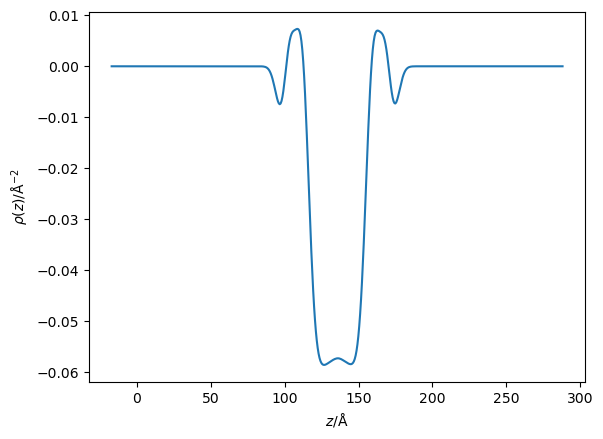

In [48]:
plt.plot(sim.sld_profile()[0], sim.sld_profile()[1])
plt.xlabel('$z$/Å')
plt.ylabel(r'$\rho(z)$/Å$^{-2}$')
plt.savefig('SLD_profile_AA.png', dpi=300, bbox_inches='tight')
plt.show()